In [ ]:
!pip install segmentation-models
!pip install nibabel
!pip install nilearn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import warnings
warnings.filterwarnings('ignore')
import gc
from tensorflow import keras
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import nilearn as nil
import scipy.ndimage as ndi
import tensorflow as tf
import segmentation_models as sm
import random


In [ ]:
# from skimage import io
# !pip install patchify
# from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
def expand_greyscale_image_channels(grey_image):
    grey_image_arr = np.array(grey_image)
    grey_image_arr = np.expand_dims(grey_image_arr, -1)
    grey_image_arr_3_channel = grey_image_arr.repeat(3, axis=-1)
    return grey_image_arr_3_channel

In [ ]:

def data_preprocessing(path,label):
    print("Loading ::",path)
    train_temp=[]
    masks_temp=[]
    img_tr = nib.load(path).get_fdata()

    # img_tr_scaled = min_max_scaling(img_tr)

    mask_tr = nib.load(label).get_fdata()
    print(img_tr.shape, mask_tr.shape)
    print(img_tr[2].max())
    for img in range(0, img_tr.shape[2]):
            clean_img=np.clip(img_tr[:,:,img],0,255)
            clean_mask=np.clip(mask_tr[:,:,img],0,255)
            train_temp.append(clean_img)
            masks_temp.append(clean_mask)

    #n=random.randint(30,len(empty_train))
    #train_temp.extend(empty_train[:n,:,:])
    #masks_temp.extend(empty_masks[:n,:,:])
    #expanding diminetions outside this fuction for ploting capabilities


    #train_temp=expand_greyscale_image_channels(train_temp)
    #mask_temp=np.expand_dims(masks_temp, axis=3)

    return train_temp,masks_temp




In [ ]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Binary crossentropy')
  ax1.grid(True)

  ax2.plot(history.history['iou_score'], label='iou_score')
  ax2.plot(history.history['val_iou_score'], label='val_iou_score')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.grid(True)

  plt.show()

In [ ]:
path = '/content/drive/My Drive/ProxmedImg006_NCCT.nii'
my_img  = nib.load(path)
nii_data = my_img.get_fdata()
nii_aff  = my_img.affine
nii_hdr  = my_img.header
print(nii_aff ,'\n',nii_hdr)
print(nii_data.shape)

[[-4.67999995e-01  0.00000000e+00  0.00000000e+00  1.19764999e+02]
 [ 0.00000000e+00 -4.67999995e-01  0.00000000e+00  1.19765602e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -5.54500000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] 
 <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512  58   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.    0.468 0.468 3.    0.    0.    0.    0.   ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin    

In [ ]:
test_load = nib.load('/content/drive/My Drive/ProxmedImg006_NCCT.nii').get_fdata()
print(test_load.min())

-2048.0


In [ ]:
def min_max_scaling(data):

    min_val = data.min()
    max_val = data.max()

    reshaped_data = data.reshape((-1, data.shape[-1]))
    scaled_data = (reshaped_data - min_val) / (max_val - min_val)
    return scaled_data.reshape(data.shape)

    # return (value - min_val / max_val - min_val )

# scaled_data = min_max_scaling(test_load)

# print(scaled_data.mean())

In [ ]:
label_load = nib.load('/content/drive/My Drive/ProxmedImg006_ROI.nii').get_fdata()
print(label_load.shape)

print(np.unique(label_load))

(512, 512, 58)
[0. 1.]


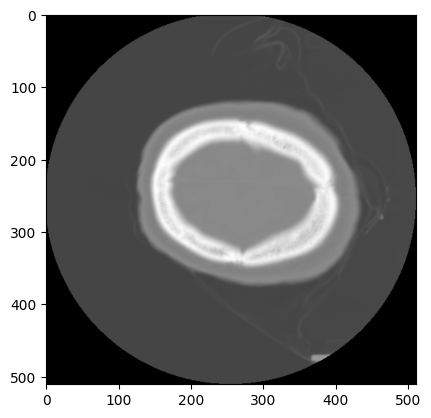

In [ ]:
plt.imshow(test_load[1:,1:,49],cmap='gray')
plt.show()

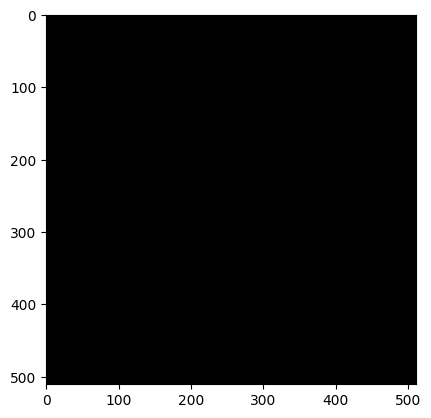

In [ ]:
plt.imshow(label_load[1:,1:,14],cmap='gray')
plt.show()

# New Section

In [ ]:
path = r'/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA'
all_files = os.listdir(path)

image_paths = []
label_paths = []
segmentation_paths = []

for file in all_files:
    path_ = os.path.join(path, file)
    train_ids = next(os.walk(path_))[2]

    for file_path in train_ids:
        full_path = os.path.join(path_, file_path)

        if 'ROI' in file_path or 'segmentation' in file_path:
            label_paths.append(full_path)
        else:
            image_paths.append(full_path)

# Creating DataFrame
df = {
    'path': image_paths,
    'label': label_paths
}

In [ ]:
#test_df to check to test the model on unseen data
test_df={'path':df['path'][-1],'label':df['label'][-1]}
df['path'].pop(-1),df['label'].pop(-1)


('/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg043/ProxmedImg043_NCCT.nii.gz',
 '/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg043/ProxmedImg043_ROI.nii.gz')

In [ ]:
df

{'path': ['/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg006/ProxmedImg006_NCCT.nii.gz',
  '/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg014/ProxmedImg014_NCCT.nii.gz',
  '/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg022/ProxmedImg022_NCCT.nii.gz',
  '/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg331/ProxmedImg331_NCCT.nii.gz',
  '/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg025/ProxmedImg025_NCCT.nii.gz',
  '/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg013/ProxmedImg013_NCCT.nii.gz',
  '/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg021/ProxmedImg021_NCCT.nii.gz'],
 'label': ['/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg006/ProxmedImg006_ROI.nii.gz',
  '/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg014/ProxmedImg014_ROI.nii.gz',
  '/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/Proxme

In [ ]:
test_df

{'path': '/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg043/ProxmedImg043_NCCT.nii.gz',
 'label': '/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg043/ProxmedImg043_ROI.nii.gz'}

In [ ]:
strategy = tf.distribute.MirroredStrategy()
#batch_size = batch_size * strategy.num_replicas_in_sync
with strategy.scope():

    model=sm.Unet('resnet34',encoder_weights='imagenet')
    model.compile(optimizer='Adam', loss=sm.losses.bce_jaccard_loss,metrics=[sm.metrics.iou_score])

es_val = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
es_loss = EarlyStopping(monitor='loss', mode='min', verbose=1)

In [ ]:
# Train Loop


preprocess_input=sm.get_preprocessing('resnet34')
epoch=10
for i in range(5):
    for path, label in zip(df['path'],df['label']):

      gc.collect()
      X_train,y_train=data_preprocessing(path,label)



      #converting X_train,y_train into ndim numpy arrays

      X_train=np.array(X_train)
      y_train=np.array(y_train)



      #Exapnding X_train to have 3 Channels, y-train to have 1 Channel
      print("Expanding Dimentions")
      X_train=expand_greyscale_image_channels(X_train)
      y_train=np.expand_dims(y_train,axis=3)

      print(X_train.shape)
      print(y_train.shape)

      #converting into tensors
      print("Transforming into Tensor")

      X_train=tf.convert_to_tensor(X_train)
      y_train=tf.convert_to_tensor(y_train)

      #Parsing through the built in data preprocessing fuctions for safety

      X_train=preprocess_input(X_train)
      y_train=preprocess_input(y_train)

      print("preprocessed_input")
      print(X_train.shape)
      print(y_train.shape)

      print("Traning model")
      histroy=model.fit(X_train,y_train,batch_size=16,epochs=epoch, verbose=1, validation_split=0.3)

      del X_train,y_train


Loading :: /content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg006/ProxmedImg006_NCCT.nii.gz
(512, 512, 58) (512, 512, 58)
-846.0
Expanding Dimentions
(58, 512, 512, 3)
(58, 512, 512, 1)
Transforming into Tensor
preprocessed_input
(58, 512, 512, 3)
(58, 512, 512, 1)
Traning model
Epoch 1/10
3/3 [==============================] - 3s 859ms/step - loss: 1.2911 - iou_score: 0.0040 - val_loss: 7406220.5000 - val_iou_score: 0.0080
Epoch 2/10
3/3 [==============================] - 3s 891ms/step - loss: 1.2619 - iou_score: 0.0032 - val_loss: 161229.4219 - val_iou_score: 2.4810e-04
Epoch 3/10
3/3 [==============================] - 3s 891ms/step - loss: 1.2400 - iou_score: 0.0037 - val_loss: 289691.8750 - val_iou_score: 4.0478e-10
Epoch 4/10
3/3 [==============================] - 3s 842ms/step - loss: 1.2154 - iou_score: 0.0037 - val_loss: 170732.0938 - val_iou_score: 4.3226e-10
Epoch 5/10
3/3 [==============================] - 3s 837ms/step - loss: 1.1968 - iou_score: 0.0037 - va

In [ ]:
# print(model.summary())

In [ ]:
model.save('brain-train-08-12.h5')

In [ ]:
print(histroy.history)

{'loss': [1.1672712564468384], 'iou_score': [0.03122078999876976], 'val_loss': [1.0791950225830078], 'val_iou_score': [5.400404552347027e-05]}


In [ ]:
df['label']

['/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg006/ProxmedImg006_ROI.nii.gz',
 '/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg014/ProxmedImg014_ROI.nii.gz',
 '/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg022/ProxmedImg022_ROI.nii.gz',
 '/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg331/ProxmedImg331_ROI.nii.gz',
 '/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg025/ProxmedImg025_ROI.nii.gz',
 '/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg013/ProxmedImg013_ROI.nii.gz',
 '/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg021/ProxmedImg021_ROI.nii.gz']

Loading :: /content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg006/ProxmedImg006_NCCT.nii.gz
(512, 512, 58) (512, 512, 58)
-846.0
/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg006/ProxmedImg006_NCCT.nii.gz
/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg006/ProxmedImg006_ROI.nii.gz
Expanding Dimentions
(58, 512, 512, 3)
(58, 512, 512, 1)
Transforming into Tensor
preprocessed_input
(58, 512, 512, 3)
(58, 512, 512, 1)
2/2 [==============================] - 1s 509ms/step
(58, 512, 512, 1)


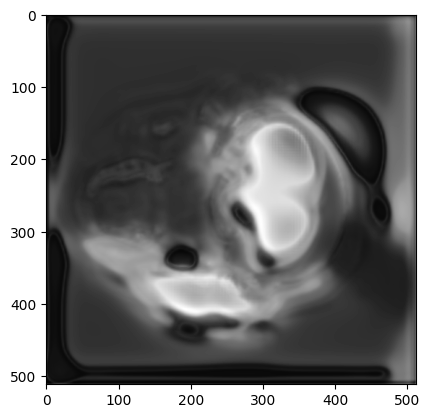

Loading :: /content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg014/ProxmedImg014_NCCT.nii.gz
(512, 512, 40) (512, 512, 40)
319.0
/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg014/ProxmedImg014_NCCT.nii.gz
/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg014/ProxmedImg014_ROI.nii.gz
Expanding Dimentions
(40, 512, 512, 3)
(40, 512, 512, 1)
Transforming into Tensor
preprocessed_input
(40, 512, 512, 3)
(40, 512, 512, 1)
2/2 [==============================] - 1s 506ms/step
(40, 512, 512, 1)


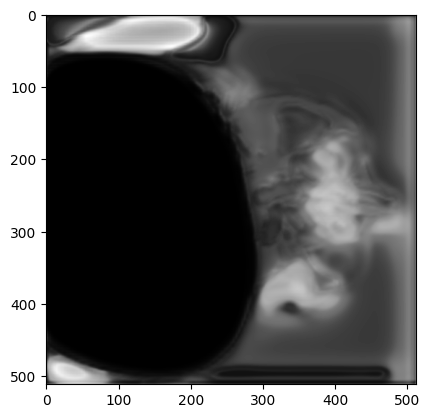

Loading :: /content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg022/ProxmedImg022_NCCT.nii.gz
(512, 512, 28) (512, 512, 28)
-817.0
/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg022/ProxmedImg022_NCCT.nii.gz
/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg022/ProxmedImg022_ROI.nii.gz
Expanding Dimentions
(28, 512, 512, 3)
(28, 512, 512, 1)
Transforming into Tensor
preprocessed_input
(28, 512, 512, 3)
(28, 512, 512, 1)
1/1 [==============================] - 0s 205ms/step
(28, 512, 512, 1)


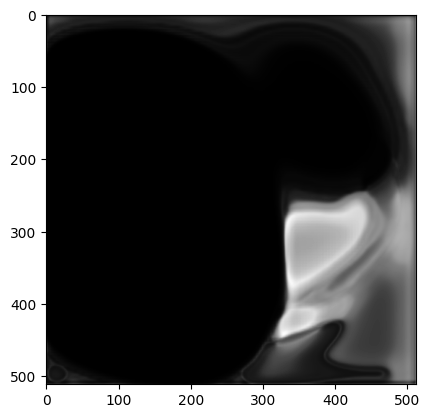

Loading :: /content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg331/ProxmedImg331_NCCT.nii.gz
(512, 512, 35) (512, 512, 35)
325.0
/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg331/ProxmedImg331_NCCT.nii.gz
/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg331/ProxmedImg331_ROI.nii.gz
Expanding Dimentions
(35, 512, 512, 3)
(35, 512, 512, 1)
Transforming into Tensor
preprocessed_input
(35, 512, 512, 3)
(35, 512, 512, 1)
2/2 [==============================] - 1s 497ms/step
(35, 512, 512, 1)


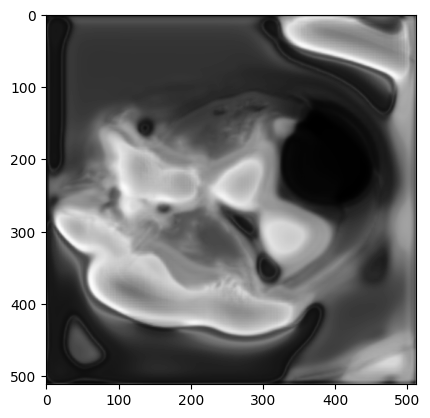

Loading :: /content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg025/ProxmedImg025_NCCT.nii.gz
(512, 512, 31) (512, 512, 31)
333.0
/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg025/ProxmedImg025_NCCT.nii.gz
/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg025/ProxmedImg025_ROI.nii.gz
Expanding Dimentions
(31, 512, 512, 3)
(31, 512, 512, 1)
Transforming into Tensor
preprocessed_input
(31, 512, 512, 3)
(31, 512, 512, 1)
1/1 [==============================] - 0s 298ms/step
(31, 512, 512, 1)


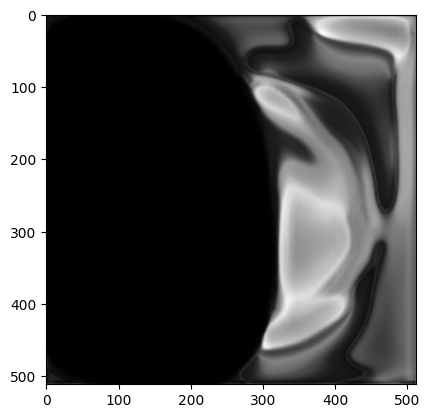

Loading :: /content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg013/ProxmedImg013_NCCT.nii.gz
(512, 512, 31) (512, 512, 31)
241.0
/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg013/ProxmedImg013_NCCT.nii.gz
/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg013/ProxmedImg013_ROI.nii.gz
Expanding Dimentions
(31, 512, 512, 3)
(31, 512, 512, 1)
Transforming into Tensor
preprocessed_input
(31, 512, 512, 3)
(31, 512, 512, 1)
1/1 [==============================] - 0s 222ms/step
(31, 512, 512, 1)


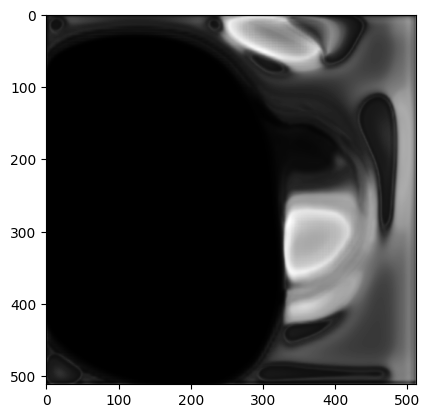

Loading :: /content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg021/ProxmedImg021_NCCT.nii.gz
(512, 512, 36) (512, 512, 36)
21.0
/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg021/ProxmedImg021_NCCT.nii.gz
/content/drive/My Drive/Colab Notebooks/HYPODENSITY-DATA/ProxmedImg021/ProxmedImg021_ROI.nii.gz
Expanding Dimentions
(36, 512, 512, 3)
(36, 512, 512, 1)
Transforming into Tensor
preprocessed_input
(36, 512, 512, 3)
(36, 512, 512, 1)
2/2 [==============================] - 1s 514ms/step
(36, 512, 512, 1)


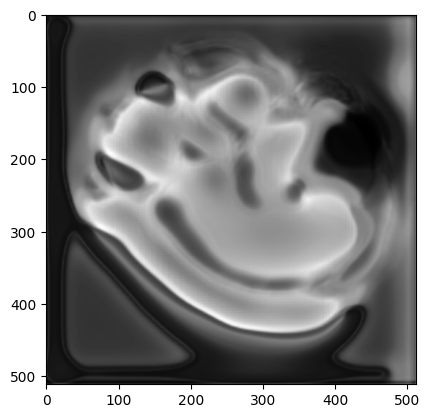

In [ ]:
for path, label in zip(df['path'],df['label']):

      gc.collect()
      X_train,y_train=data_preprocessing(path,label)

      print(path)
      print(label)

      #converting X_train,y_train into ndim numpy arrays

      X_train=np.array(X_train)
      y_train=np.array(y_train)



      #Exapnding X_train to have 3 Channels, y-train to have 1 Channel
      print("Expanding Dimentions")
      X_train=expand_greyscale_image_channels(X_train)
      y_train=np.expand_dims(y_train,axis=3)

      print(X_train.shape)
      print(y_train.shape)

      #converting into tensors
      print("Transforming into Tensor")

      X_train=tf.convert_to_tensor(X_train)
      y_train=tf.convert_to_tensor(y_train)

      #Parsing through the built in data preprocessing fuctions for safety

      X_train=preprocess_input(X_train)
      y_train=preprocess_input(y_train)

      print("preprocessed_input")
      print(X_train.shape)
      print(y_train.shape)

      y_pred = model.predict(X_train)
      print(y_pred.shape)

      # y_pred_reshaped = np.reshape(y_pred, (58, 512, 512))

      # y_pred_reshaped = np.transpose(y_pred_reshaped, (1,2,0))
      plt.title(f"Sample output of the mask")
      plt.imshow(y_pred[10,:,:,:],cmap='gray')
      plt.show()